# Binary Classification: Using Penalized Linear Regression to Detect Unexploded Mines
****

In [9]:
import urllib.request, urllib.error, urllib.parse
from math import sqrt, fabs, exp
import matplotlib.pyplot as plot
from sklearn.linear_model import enet_path
from sklearn.metrics import roc_auc_score, roc_curve
import numpy

In [21]:
#read data from uci data repository
target_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"
data = urllib.request.urlopen(target_url)

In [22]:
#arrange data into list for labels and list of lists for attributes
xList = []


for line in data:
    #split on comma
    row = line.decode().strip().split(",")
    xList.append(row)

#separate labels from attributes, convert from attributes from string to numeric and convert "M" to 1 and "R" to 0

xNum = []
labels = []

for row in xList:
    lastCol = row.pop()
    if lastCol == "M":
        labels.append(1.0)
    else:
        labels.append(0.0)
    attrRow = [float(elt) for elt in row]
    xNum.append(attrRow)

In [36]:
#number of rows and columns in x matrix
nrow = len(xNum)
ncol = len(xNum[1])

#calculate means and variances
xMeans = []
xSD = []
for i in range(ncol):
    col = [xNum[j][i] for j in range(nrow)]
    mean = sum(col)/nrow
    xMeans.append(mean)
    colDiff = [(xNum[j][i] - mean) for j in range(nrow)]
    sumSq = sum([colDiff[i] * colDiff[i] for i in range(nrow)])
    stdDev = sqrt(sumSq/nrow)
    xSD.append(stdDev)

#use calculate mean and standard deviation to normalize xNum
xNormalized = []
for i in range(nrow):
    rowNormalized = [(xNum[i][j] - xMeans[j])/xSD[j] for j in range(ncol)]
    xNormalized.append(rowNormalized)

#normalize labels to center
#Normalize labels
meanLabel = sum(labels)/nrow
sdLabel = sqrt(sum([(labels[i] - meanLabel) * (labels[i] - meanLabel) for i in range(nrow)])/nrow)

labelNormalized = [(labels[i] - meanLabel)/sdLabel for i in range(nrow)]



In [37]:
#number of cross validation folds
nxval = 10


for ixval in range(nxval):
    #Define test and training index sets
    idxTest = [a for a in range(nrow) if a%nxval == ixval%nxval]
    idxTrain = [a for a in range(nrow) if a%nxval != ixval%nxval]

    #Define test and training attribute and label sets
    xTrain = numpy.array([xNormalized[r] for r in idxTrain])
    xTest = numpy.array([xNormalized[r] for r in idxTest])
    labelTrain = numpy.array([labelNormalized[r] for r in idxTrain])
    labelTest = numpy.array([labelNormalized[r] for r in idxTest])

    alphas, coefs, _ = enet_path(xTrain, labelTrain,l1_ratio=0.8, fit_intercept=False, return_models=False)

    #apply coefs to test data to produce predictions and accumulate
    if ixval == 0:
        pred = numpy.dot(xTest, coefs)
        yOut = labelTest
    else:
        #accumulate predictions
        yTemp = numpy.array(yOut)
        yOut = numpy.concatenate((yTemp, labelTest), axis=0)

        #accumulate predictions
        predTemp = numpy.array(pred)
        pred = numpy.concatenate((predTemp, numpy.dot(xTest, coefs)), axis = 0)


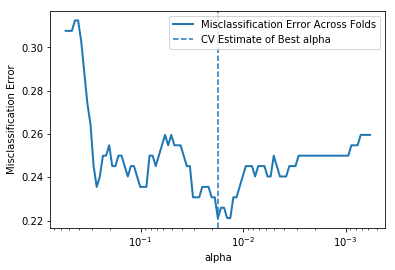

In [38]:
#calculate miss classification error
misClassRate = []
_,nPred = pred.shape
for iPred in range(1, nPred):
    predList = list(pred[:, iPred])
    errCnt = 0.0
    for irow in range(nrow):
        if (predList[irow] < 0.0) and (yOut[irow] >= 0.0):
            errCnt += 1.0
        elif (predList[irow] >= 0.0) and (yOut[irow] < 0.0):
            errCnt += 1.0
    misClassRate.append(errCnt/nrow)

#find minimum point for plot and for print
minError = min(misClassRate)
idxMin = misClassRate.index(minError)
plotAlphas = list(alphas[1:len(alphas)])

plot.figure()
plot.plot(plotAlphas, misClassRate, label='Misclassification Error Across Folds', linewidth=2)
plot.axvline(plotAlphas[idxMin], linestyle='--',
            label='CV Estimate of Best alpha')
plot.legend()
plot.semilogx()
ax = plot.gca()
ax.invert_xaxis()
plot.xlabel('alpha')
plot.ylabel('Misclassification Error')
plot.axis('tight')
plot.show()

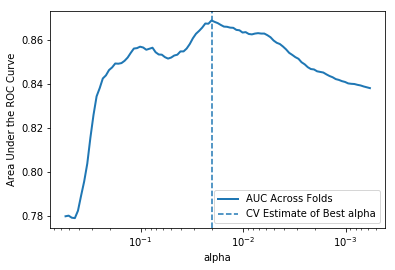

In [39]:
#calculate AUC.
idxPos = [i for i in range(nrow) if yOut[i] > 0.0]
yOutBin = [0] * nrow
for i in idxPos: yOutBin[i] = 1

auc = []
for iPred in range(1, nPred):
    predList = list(pred[:, iPred])
    aucCalc = roc_auc_score(yOutBin, predList)
    auc.append(aucCalc)

maxAUC = max(auc)
idxMax = auc.index(maxAUC)

plot.figure()
plot.plot(plotAlphas, auc, label='AUC Across Folds', linewidth=2)
plot.axvline(plotAlphas[idxMax], linestyle='--',
            label='CV Estimate of Best alpha')
plot.legend()
plot.semilogx()
ax = plot.gca()
ax.invert_xaxis()
plot.xlabel('alpha')
plot.ylabel('Area Under the ROC Curve')
plot.axis('tight')
plot.show()


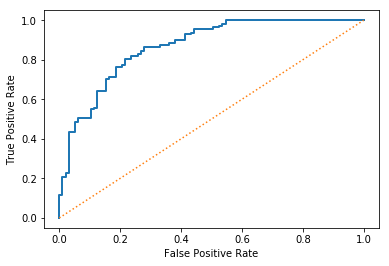

Best Value of Misclassification Error =  0.22115384615384615
Best alpha for Misclassification Error =  0.017686244720179375

Best Value for AUC =  0.8686727965078481
Best alpha for AUC   =   0.020334883589342503

Confusion Matrices for Different Threshold Values


In [40]:
#plot best version of ROC curve
fpr, tpr, thresh = roc_curve(yOutBin, list(pred[:, idxMax]))
ctClass = [i*0.01 for i in range(101)]

plot.plot(fpr, tpr, linewidth=2)
plot.plot(ctClass, ctClass, linestyle=':')
plot.xlabel('False Positive Rate')
plot.ylabel('True Positive Rate')
plot.show()

print('Best Value of Misclassification Error = ', misClassRate[idxMin])
print('Best alpha for Misclassification Error = ', plotAlphas[idxMin])
print('')
print('Best Value for AUC = ', auc[idxMax])
print('Best alpha for AUC   =  ', plotAlphas[idxMax])

print('')
print('Confusion Matrices for Different Threshold Values')

In [41]:
#pick some points along the curve to print.  There are 57 points.  The extremes aren't useful
#Sample at 14, 28 and 42.  Use the calculated values of tpr and fpr along with definitions and
#threshold values.
#Some nomenclature (e.g. see wikkipedia "receiver operating curve")


#P = Positive cases
P = len(idxPos)
#N = Negative cases
N = nrow - P
#TP = True positives = tpr * P
TP = tpr[14] * P
#FN = False negatives = P - TP
FN = P - TP
#FP = False positives = fpr * N
FP = fpr[14] * N
#TN = True negatives = N - FP
TN = N - FP

print('Threshold Value =   ', thresh[14])
print('TP = ', TP, 'FP = ', FP)
print('FN = ', FN, 'TN = ', TN)

TP = tpr[28] * P; FN = P - TP; FP = fpr[28] * N; TN = N - FP

print('Threshold Value =   ', thresh[28])
print('TP = ', TP, 'FP = ', FP)
print('FN = ', FN, 'TN = ', TN)

TP = tpr[42] * P; FN = P - TP; FP = fpr[42] * N; TN = N - FP

print('Threshold Value =   ', thresh[42])
print('TP = ', TP, 'FP = ', FP)
print('FN = ', FN, 'TN = ', TN)

Threshold Value =    0.22367335096010946
TP =  61.00000000000001 FP =  10.0
FN =  49.99999999999999 TN =  87.0
Threshold Value =    -0.08075971512781846
TP =  89.0 FP =  21.0
FN =  22.0 TN =  76.0
Threshold Value =    -0.3003803719324685
TP =  100.0 FP =  37.0
FN =  11.0 TN =  60.0


## Build Classifier for Deployment for full dataset

In [43]:
#Convert normalized labels to numpy array
Y = numpy.array(labelNormalized)

#Convert normalized attributes to numpy array
X = numpy.array(xNormalized)

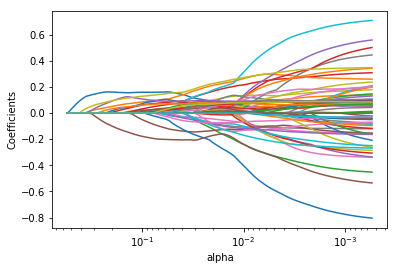

In [49]:
alphas, coefs, _ = enet_path(X, Y,l1_ratio=0.8, fit_intercept=False, return_models=False)

plot.plot(alphas,coefs.T)
plot.semilogx()
ax = plot.gca()
ax.invert_xaxis()
plot.xlabel('alpha')
plot.ylabel('Coefficients')
plot.axis('tight')

plot.show()

In [50]:
nattr, nalpha = coefs.shape

#find coefficient ordering
nzList = []
for iAlpha in range(1,nalpha):
    coefList = list(coefs[: ,iAlpha])
    nzCoef = [index for index in range(nattr) if coefList[index] != 0.0]
    for q in nzCoef:
        if not(q in nzList):
            nzList.append(q)

#make up names for columns of X
names = ['V' + str(i) for i in range(ncol)]
nameList = [names[nzList[i]] for i in range(len(nzList))]
print("Attributes Ordered by How Early They Enter the Model")
print(nameList)
print('')

Attributes Ordered by How Early They Enter the Model
['V10', 'V48', 'V11', 'V44', 'V35', 'V51', 'V20', 'V3', 'V21', 'V45', 'V43', 'V15', 'V0', 'V22', 'V27', 'V50', 'V53', 'V30', 'V58', 'V56', 'V28', 'V39', 'V46', 'V19', 'V54', 'V29', 'V57', 'V6', 'V8', 'V7', 'V49', 'V2', 'V23', 'V37', 'V55', 'V4', 'V13', 'V36', 'V38', 'V26', 'V31', 'V1', 'V34', 'V33', 'V24', 'V16', 'V17', 'V5', 'V52', 'V41', 'V40', 'V59', 'V12', 'V9', 'V18', 'V14', 'V47', 'V42']



In [51]:
#find coefficients corresponding to best alpha value. alpha value corresponding to
#normalized X and normalized Y is 0.020334883589342503

alphaStar = 0.020334883589342503
indexLTalphaStar = [index for index in range(100) if alphas[index] > alphaStar]
indexStar = max(indexLTalphaStar)

#here's the set of coefficients to deploy
coefStar = list(coefs[:,indexStar])
print("Best Coefficient Values ")
print(coefStar)
print('')

#The coefficients on normalized attributes give another slightly different ordering

absCoef = [abs(a) for a in coefStar]

#sort by magnitude
coefSorted = sorted(absCoef, reverse=True)

idxCoefSize = [absCoef.index(a) for a in coefSorted if not(a == 0.0)]

namesList2 = [names[idxCoefSize[i]] for i in range(len(idxCoefSize))]

print("Attributes Ordered by Coef Size at Optimum alpha")
print(namesList2)

Best Coefficient Values 
[0.08225825681376644, 0.002061988722005447, -0.11828642590856134, 0.16633956932499885, 0.0042854388193717475, -0.0, -0.04366252474594146, -0.0775151048794286, 0.10000054356323651, 0.0, 0.09061720703628098, 0.21210870399915818, -0.0, -0.010655386149822128, -0.0, -0.13328659558143685, -0.0, 0.0, 0.0, 0.05281485450141613, 0.03853115479672475, 0.003551534818179128, 0.09085471468038399, 0.03031611390402431, -0.0, 0.0, 0.008619554235748473, 0.0, 0.0, 0.17497679257272572, -0.2215687804617215, 0.01261424382793801, 0.0, -0.0, 0.0, -0.17160601809439624, -0.08045001382421423, 0.07809679004152409, 0.02203528761676172, -0.07218440927369019, 0.0, -0.0, 0.0, 0.05701881687625017, 0.0964782656857232, 0.039917367637232685, 0.049158231541627045, 0.0, 0.2267191792012368, -0.09627273547995183, 0.0, 0.07888678433222547, 0.0, 0.062312821755757086, -0.08278551071329494, 0.014466967172068131, -0.07432652752563267, 0.06809647597425748, 0.07048886443547711, 0.0]

Attributes Ordered by Co